In [1]:
from netCDF4 import Dataset
import numpy as np

In [2]:
filename='Slab2Distribute_Mar2018/png_slab2_dep_02.26.18.grd'
nc_fid=Dataset(filename,'r')

In [3]:
nc_fid.variables

{'x': <class 'netCDF4._netCDF4.Variable'>
 float64 x(x)
     long_name: x
     actual_range: [128. 147.]
 unlimited dimensions: 
 current shape = (381,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'y': <class 'netCDF4._netCDF4.Variable'>
 float64 y(y)
     long_name: y
     actual_range: [-9.  5.]
 unlimited dimensions: 
 current shape = (281,)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'z': <class 'netCDF4._netCDF4.Variable'>
 float32 z(y, x)
     long_name: z
     _FillValue: nan
     actual_range: [-173.0065918    -5.44455147]
 unlimited dimensions: 
 current shape = (281, 381)
 filling on}

In [4]:
x = nc_fid.variables['x'][:]
y = nc_fid.variables['y'][:]
z = nc_fid.variables["z"][:]

In [5]:
nx = x.shape[0]
ny = y.shape[0]
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
dx, dy = (xmax - xmin) / nx, (ymax - ymin) / ny

In [6]:
mask = z.mask

x, y = np.meshgrid(x, y)
x = x[mask == False]
y = y[mask == False]
z = z[mask == False]

In [7]:
import matplotlib.pylab as plt

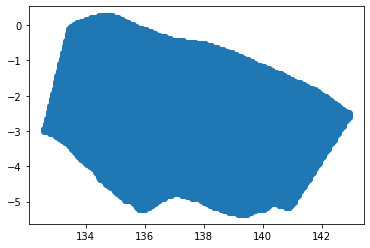

In [8]:
plt.scatter(x.flatten(), y.flatten())

In [9]:
from scipy.interpolate import griddata
from scipy.interpolate import interp2d

xi = np.linspace(xmin,xmax,nx)
yi = np.linspace(ymin,ymax,ny)
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='nearest')

In [10]:
from skimage.filters import gaussian

for i in range(4):
    zi = gaussian(zi, sigma=5, preserve_range=True)

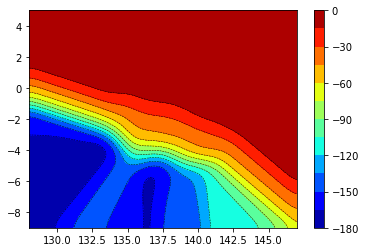

In [11]:
CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
plt.show()

## Extract the contour of the slab

In [12]:
values = np.where(mask, 0, 1)

In [13]:
for val in range(4):
    values = gaussian(values, 3, preserve_range=True)

In [14]:
from skimage import measure

In [15]:
around = measure.find_contours(values, 0.5)

In [16]:
around

[array([[184.18546113, 140.        ],
        [184.38616952, 139.        ],
        [184.55667189, 138.        ],
        ...,
        [183.95522669, 141.        ],
        [184.        , 140.80672127],
        [184.18546113, 140.        ]])]

In [17]:
i = around[0][:,0]
j = around[0][:,1]
i = np.round(i).astype("int")
j = np.round(j).astype("int") 

In [18]:
x1 = xmin + (j - 0.5) * dx
y1 = ymin + (i - 0.5) * dy
z1 = zi[i, j]

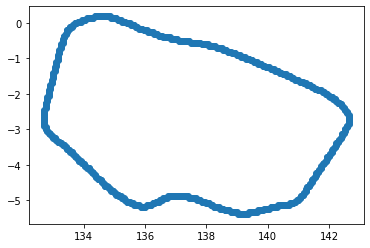

In [19]:
plt.scatter(x1, y1)

In [20]:
from shapely.geometry import LinearRing

In [21]:
contour = LinearRing(zip(x1, y1, z1.flatten()))

In [22]:
len(contour.coords)

635

In [23]:
contour = contour.simplify(0.05)

In [24]:
len(contour.coords)

27

In [25]:
x1, y1 = contour.coords.xy

## Mesh the extend of the slab


In [26]:

import gmsh
gmsh.initialize()
gmsh.model.add("test")

#gmsh.option.setNumber("Mesh.MeshSizeMax", 0.1)

In [27]:
pts_list = []
for idx in range(len(x1)-1):
        pt = gmsh.model.geo.add_point(x1[idx], y1[idx], 0)
        pts_list.append(pt)
        
if pts_list:
    pts_list = pts_list + [pts_list[0]]
    line_list = []
    for idx in range(len(pts_list)-1):
        pt1 = pts_list[idx]
        pt2 = pts_list[idx+1]
        line_list.append(gmsh.model.geo.add_line(pt1, pt2))

In [28]:
cl = gmsh.model.geo.add_curve_loop(line_list)
gmsh.model.geo.add_plane_surface([cl])

1

In [29]:
gmsh.model.geo.synchronize()

In [30]:
gmsh.model.mesh.generate(2)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 40%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 50%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 70%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 80%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 90%] Meshing curve 22 (Line)
Info    : [ 90%] Meshing curve 23 (Line)
Info    : [ 90%] Meshing curve 24 (Line)
I

In [31]:
#gmsh.fltk.run()

## Advect Mesh in the z-direction

### Extract Nodes and elements

In [32]:
xi.shape, yi.shape, zi.shape

((381,), (281,), (281, 381))

In [31]:
f = interp2d(xi, yi, zi)

In [32]:
nodeTags = {}
nodeCoords = {}
elementTypes = {}
elementTags = {}
elementNodeTags = {}

In [33]:
entities = gmsh.model.get_entities()

In [34]:
# get the nodes and elements
for e in entities:
    nodeTags[e], nodeCoords[e], _ = gmsh.model.mesh.getNodes(e[0], e[1])
    elementTypes[e], elementTags[e], elementNodeTags[e] = gmsh.model.mesh.getElements(e[0], e[1])

In [35]:
gmsh.model.mesh.clear()

### Advect and add elements

In [36]:
import numpy as np
import random
import math

for e in entities: 
    for i in range(2, len(nodeCoords[e]), 3):
        ii = nodeCoords[e][i-2]
        jj = nodeCoords[e][i-1]
        nodeCoords[e][i] = 0.05 * f(ii, jj)
    gmsh.model.mesh.addNodes(e[0], e[1], nodeTags[e], nodeCoords[e])
    gmsh.model.mesh.addElements(e[0], e[1], elementTypes[e], elementTags[e],
                               elementNodeTags[e])

In [37]:
gmsh.write("test.vtk")

Info    : Writing 'test.vtk'...
Info    : Done writing 'test.vtk'


In [38]:
#gmsh.fltk.run()